In [226]:
import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras import backend as K
from keras import regularizers
from keras import layers
from keras.callbacks import TensorBoard
import numpy as np

In [227]:
# Code 4: Autoencoder, One Layer, Varitional

In [228]:
encoding_dim = 32 

In [242]:
# Encoder:
input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation='relu',activity_regularizer=regularizers.l1(10e-5))(input_img)

In [243]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

In [244]:
# Variational Layer (Built into encoder model):
latent_dim = 2

z_mean = layers.Dense(latent_dim,name='mean')(encoded)
z_log_var = layers.Dense(latent_dim,name='var')(encoded)
z = layers.Lambda(sampling)([z_mean, z_log_var])
output_encoded = layers.Dense(encoding_dim,activation='relu')(z)

encoder = Model(input_img,output_encoded,name='variational')

In [245]:
# Decoder:
encoded_input = Input(shape=(encoding_dim,))
decoded = Dense(784, activation='sigmoid')(encoded_input)
decoder = Model(encoded_input,decoded,name='decoder')

In [254]:
# Combine and Compile:
autoencoder = Model(input_img,decoder(encoder(input_img)))
autoencoder.compile(optimizer='rmsprop', loss=custom_loss(autoencoder.get_layer('variational').get_layer('mean'),autoencoder.get_layer('variational').get_layer('var')))

In [255]:
# Summaries:
#autoencoder.summary()
#encoder.summary()
#variational.summary()
#decoder.summary()

In [256]:
# Variational Custom Loss Function:
def custom_loss(varlayer_mean,varlayer_var):
    def vae_loss(x, x_decoded_mean):
        xent_loss = keras.metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.mean(1 + varlayer_var.output - K.square(varlayer_mean.output) - K.exp(varlayer_var.output), axis=-1)
        return xent_loss + kl_loss
    return vae_loss

In [257]:
# Import MNIST Data:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [266]:
history = autoencoder.fit(x_train, x_train,
                          epochs=50,
                          batch_size=10,
                          shuffle=True,
                          validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 37s 625us/step - loss: 0.2636 - val_loss: 0.2629
Epoch 2/50
60000/60000 [==============================] - 32s 531us/step - loss: 0.2632 - val_loss: 0.2629
Epoch 3/50
21410/60000 [=========>....................] - ETA: 47s - loss: 0.2631

KeyboardInterrupt: 

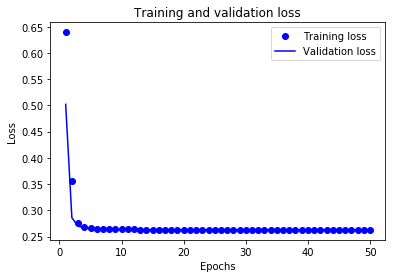

In [251]:
import matplotlib.pyplot as plt

history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, 51)

plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [252]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

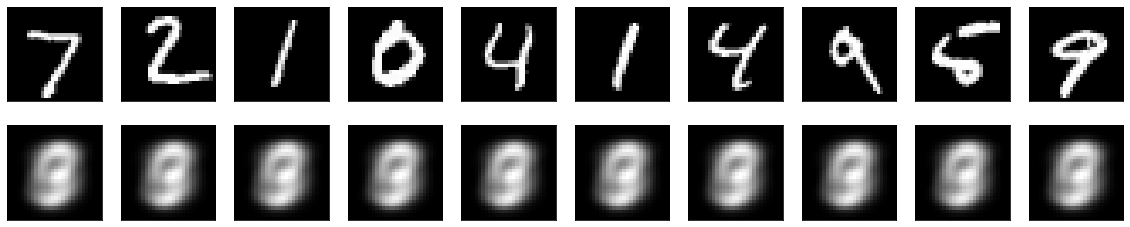

In [253]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()